<a href="https://colab.research.google.com/github/keijikk/ml_study/blob/master/kaggle_submit_from_clab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kaggleを使うための準備

In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}


Download 100%.
- path is now set to: {/content}


In [4]:
!kaggle datasets list

ref                                                 title                                               size  lastUpdated          downloadCount  
--------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
kaggle/kaggle-survey-2018                           2018 Kaggle ML & DS Survey Challenge                 4MB  2018-11-03 22:35:07           1952  
lava18/google-play-store-apps                       Google Play Store Apps                               2MB  2018-09-18 20:49:49          17463  
census/family-households-with-married-couples-data  Family Households with Married Couples Data          2KB  2018-11-07 09:42:49           1112  
kmader/skin-cancer-mnist-ham10000                   Skin Cancer MNIST: HAM10000                          3GB  2018-09-20 20:36:13           2139  
xvivancos/transactions-from-a-bakery                Transactions from a bakery                         113KB  2018-09-

In [5]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 29.7MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 25.6MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.83MB/s]


# 解析

タイタニックデータダウンロード

In [6]:
import os
os.getcwd()
os.chdir("/content/drive/My Drive/ML/kaggle/titanic")
!mkdir '/content/drive/My Drive/ML/kaggle/titanic'
!ls '/content/drive/My Drive/ML/kaggle/titanic'
!kaggle competitions download -c titanic -p '/content/drive/My Drive/ML/kaggle/titanic'


mkdir: cannot create directory ‘/content/drive/My Drive/ML/kaggle/titanic’: File exists
gender_submission.csv  predict_result_data.csv	test.csv  train.csv
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [8]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train['Embarked'] = train['Embarked'].fillna('S')# S is the most common symbol
test['Embarked'] = test['Embarked'].fillna('S')

train["Age"].fillna(train.Age.mean(), inplace=True) 
test["Age"].fillna(train.Age.mean(), inplace=True) 
test["Fare"].fillna(train.Fare.mean(), inplace=True)
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

train.head()
#test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [10]:
def get_dummied_df(df):
  df = df.drop(columns=["Name", "SibSp", "Parch", "Ticket", "Cabin" ])
  df["Pclass"] = df["Pclass"].astype(np.str)
  return pd.get_dummies(df, drop_first=False)



train_df = get_dummied_df(train)
test_df = get_dummied_df(test)

train_df.head()


,PassengerId,Survived,Age,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,7.2500,2,0,0,1,0,1,0,0,1
1,2,1,38.0,71.2833,2,1,0,0,1,0,1,0,0
2,3,1,26.0,7.9250,1,0,0,1,1,0,0,0,1
3,4,1,35.0,53.1000,2,1,0,0,1,0,0,0,1
4,5,0,35.0,8.0500,1,0,0,1,0,1,0,0,1


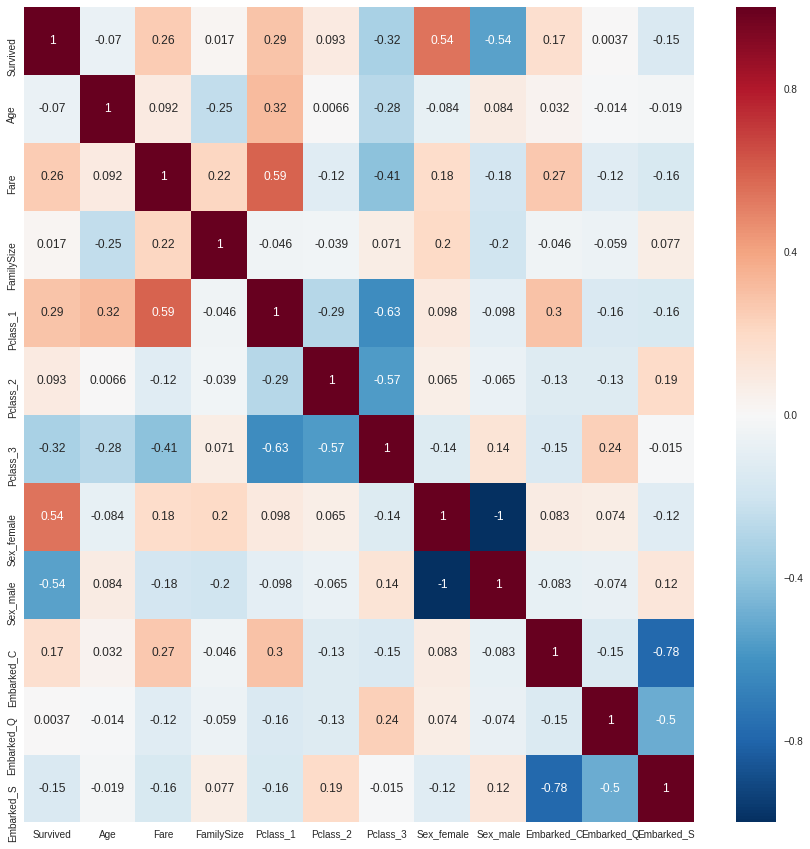

In [11]:
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
seaborn.heatmap(train_df.drop(columns=['PassengerId']).corr(), annot=True)

トレーニングデータで試してみる

In [0]:
x_df = train_df.drop(columns=['Survived'])
x_train = x_df.as_matrix()  
x_test = test_df.as_matrix()  
y_train = train_df['Survived'].as_matrix()


In [13]:
from sklearn.model_selection import train_test_split
(XX_train, XX_test,
 yy_train, yy_test) = train_test_split(
    x_train, y_train, test_size=0.3, random_state=0,
)

random_forest=RandomForestClassifier()
random_forest.fit(XX_train, yy_train)

print('Train score: {:.3f}'.format(random_forest.score(XX_train, yy_train)))
print('Test score: {:.3f}'.format(random_forest.score(XX_test, yy_test)))



Train score: 0.978
Test score: 0.802


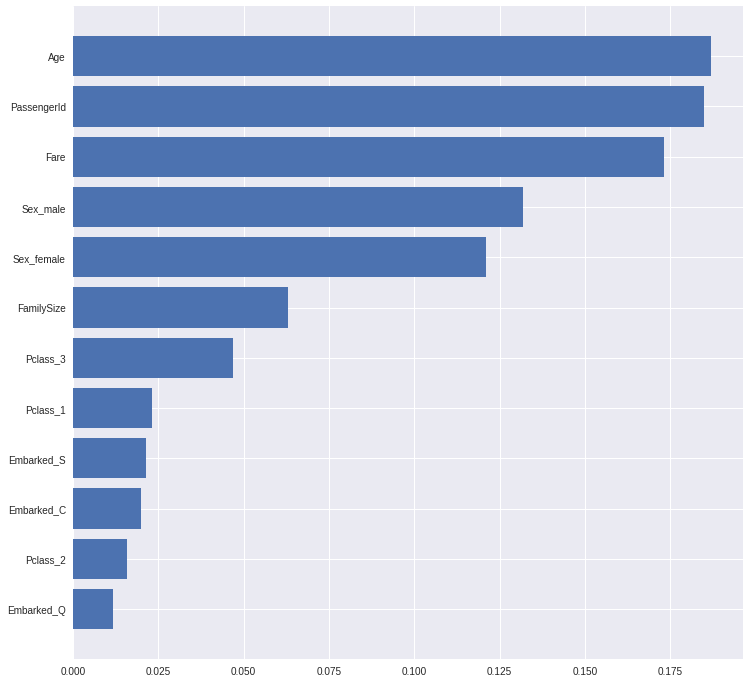

In [14]:
values, names = zip(*sorted(zip(random_forest.feature_importances_, x_df.columns)))

plt.figure(figsize=(12,12))
plt.barh(range(len(names)), values, align='center')
plt.yticks(range(len(names)), names)
plt.show()

全データで学習

In [0]:
from sklearn.ensemble import RandomForestClassifier

random_forest=RandomForestClassifier()
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(x_test)

test_df["Survived"] = Y_pred.astype(np.int)
test_df[["PassengerId", "Survived"]].to_csv("predict_result_data.csv", index=False)


# 提出

In [16]:
!ls
!kaggle competitions submit -c titanic -f predict_result_data.csv -m "submit"

gender_submission.csv  predict_result_data.csv	test.csv  train.csv
100% 2.77k/2.77k [00:01<00:00, 1.95kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster